In [1]:
# Importing libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame


In [2]:
# Reading data
data = pd.read_csv("/home/diksha/Desktop/quora_duplicate_questions.tsv", sep="\t")


In [3]:
# View first few rows of data
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Get data info 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
data.shape

(404290, 6)

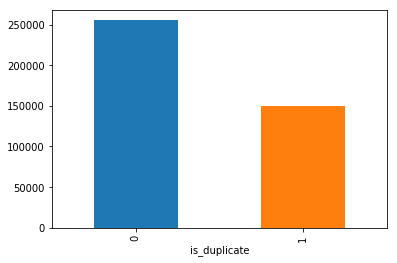

In [6]:
# Data visualization
data.groupby('is_duplicate')['id'].count().plot.bar()


In [7]:
# Total number of questions for training
print('Total number of question pairs for training: {}'.format(len(data)))

Total number of question pairs for training: 404290


In [8]:
# Percentage of duplicate questions
print('Duplicate pairs: {}%'.format(round(data['is_duplicate'].mean()*100, 2)))

Duplicate pairs: 36.92%


In [9]:
# List of all questions given in training dataset
qids = pd.Series(list(data['qid1']) + list(data['qid2']) )

In [10]:
# Number of unique questions in the training data set
print('Total number of questions in training set:{}'.format(len(np.unique(qids))))


Total number of questions in training set:537933


In [11]:
# Number of questions that appeared more than once
print('Number of questions that appear multiple times:{}'.format(np.sum(qids.value_counts()>1)))

Number of questions that appear multiple times:111780


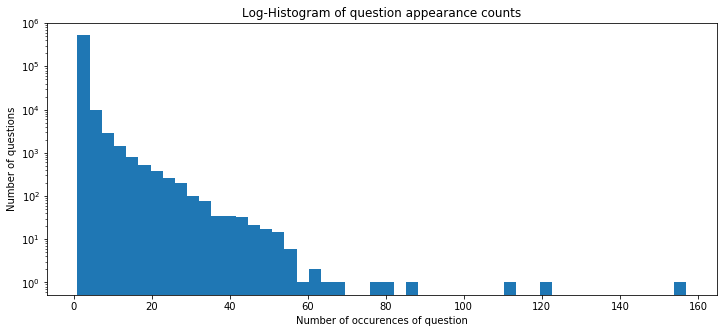

In [12]:
# Plotting histogram to see number of question vs number of occurances of question
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
plt.show()

(-0.5, 1439.5, 1079.5, -0.5)

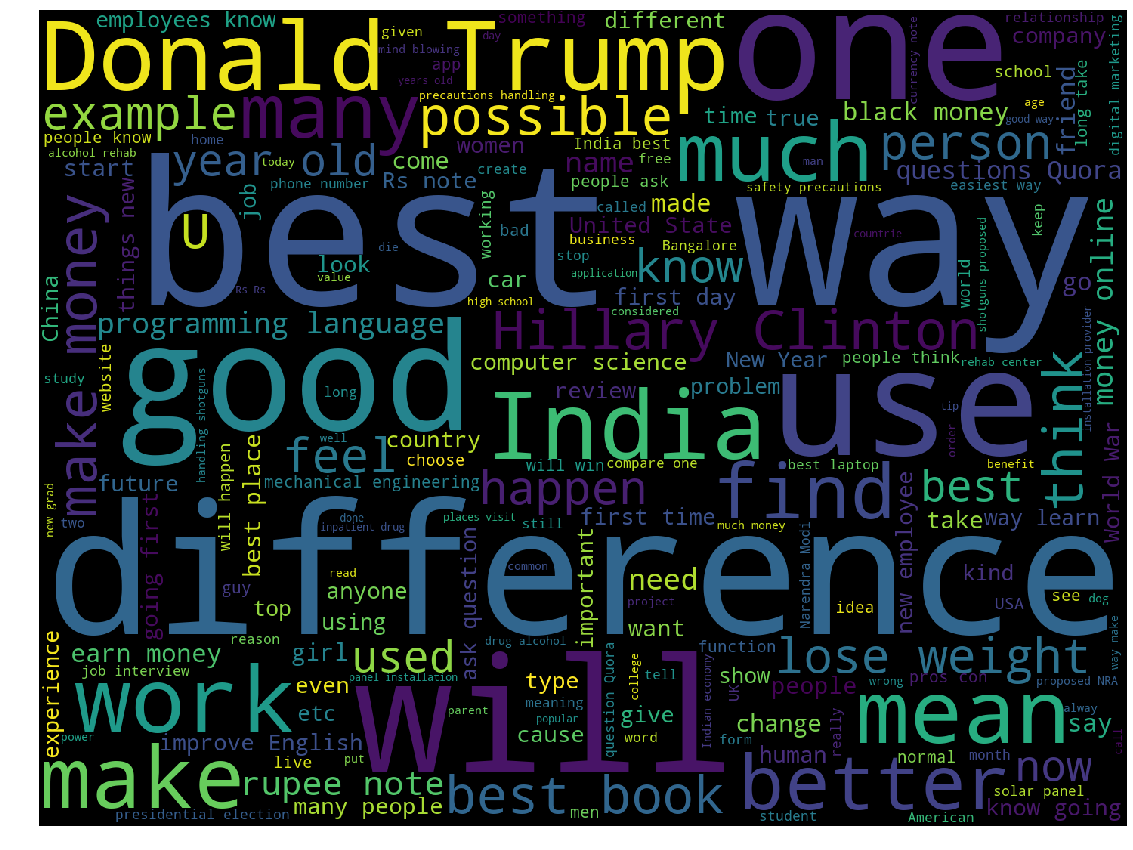

In [13]:
# View WordCloud
from wordcloud import WordCloud
train_qs= pd.Series(list(data['question1']) + list(data['question2'])).astype(str)
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [14]:
# Misc features

qmarks = np.mean(train_qs.apply(lambda x: '?' in x))
math = np.mean(train_qs.apply(lambda x: '[math]' in x))
fullstop = np.mean(train_qs.apply(lambda x: '.' in x))
capital_first = np.mean(train_qs.apply(lambda x: x[0].isupper()))
capitals = np.mean(train_qs.apply(lambda x: max([y.isupper() for y in x])))
numbers = np.mean(train_qs.apply(lambda x: max([y.isdigit() for y in x])))

print('Questions with question marks: {:.2f}%'.format(qmarks * 100))
print('Questions with [math] tags: {:.2f}%'.format(math * 100))
print('Questions with full stops: {:.2f}%'.format(fullstop * 100))
print('Questions with capitalised first letters: {:.2f}%'.format(capital_first * 100))
print('Questions with capital letters: {:.2f}%'.format(capitals * 100))
print('Questions with numbers: {:.2f}%'.format(numbers * 100))


Questions with question marks: 99.87%
Questions with [math] tags: 0.12%
Questions with full stops: 6.31%
Questions with capitalised first letters: 99.81%
Questions with capital letters: 99.95%
Questions with numbers: 11.83%


mean-train 59.82 std-train 31.96  max-train 1169.00 


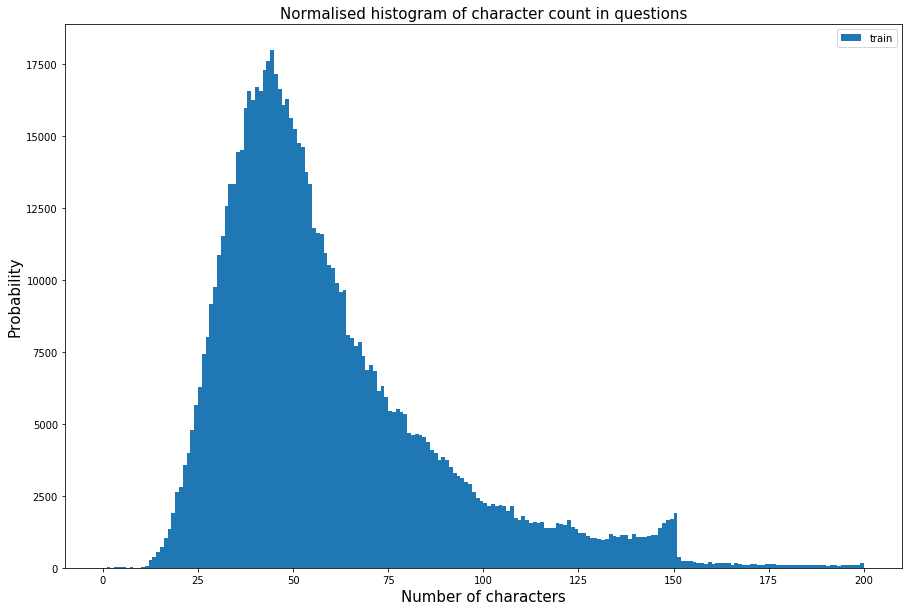

In [15]:
# Plotting Number of questions vs number of characters in the question
dist_train = train_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], label='train')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)
print('mean-train {:.2f} std-train {:.2f}  max-train {:.2f} '.format(dist_train.mean(), 
                          dist_train.std(),  dist_train.max()))

mean-train 11.06 std-train 5.89 max-train 237.00


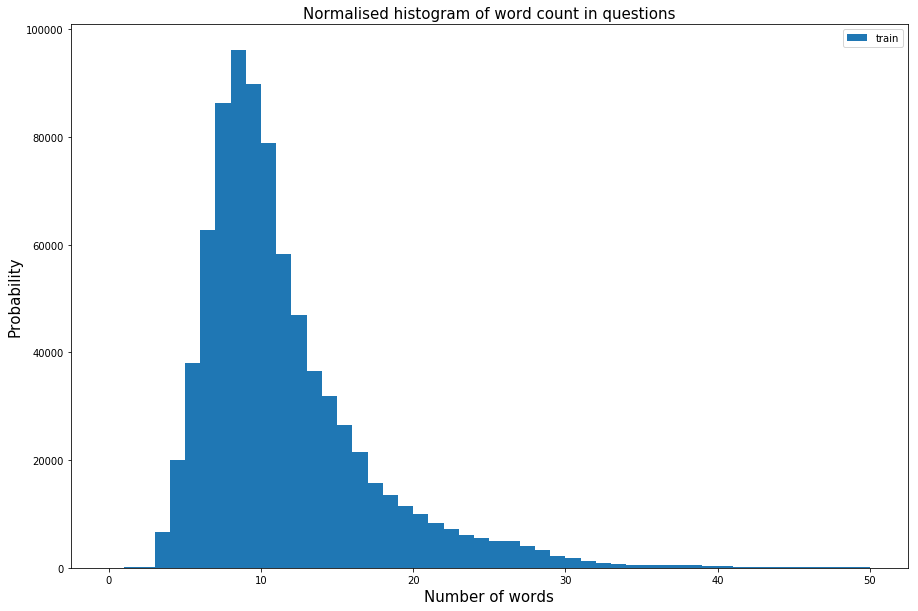

In [16]:
# Plotting Number of questions vs number of words in the question
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], label='train')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} max-train {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_train.max() ))

Text(0.5, 0, 'word_match_share')

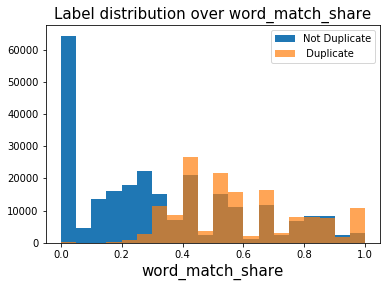

In [17]:
# Word share feature
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stopword = set(stopwords.words('english'))

def word_match_share(row):
    q1words = {}
    q2words = {}
    
    for word in str(row['question1']).lower().split():
        if word not in stopword:
            q1words[word]=1
    
    for word in str(row['question2']).lower().split():
        if word not in stopword:
            q2words[word]=1
            
    if len(q1words)==0 or len(q2words)==0:
        return 0
    
    words_in_q1 = [w for w in q1words.keys() if w in q2words] 
    words_in_q2 = [w for w in q2words.keys() if w in q1words]
    
    R = (len(words_in_q1)+len(words_in_q2))/(len(q1words)+len(q2words))
    return R

word_match = data.apply(word_match_share, axis=1, raw = True)
plt.hist(word_match[data['is_duplicate']==0],bins=20, label='Not Duplicate')
plt.hist(word_match[data['is_duplicate']==1], bins=20, alpha=0.7, label=' Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [18]:
# Weighing terms by how uncommon they are

from collections import Counter

def weight(count, eps=10000, min_count=2):
    R = 1/(count+eps) if count>=min_count else 0
    return R

eps=5000
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: weight(count) for word, count in counts.items()}


print('Most common words and weights:\n')
print(sorted(weights.items(),key = lambda x: x[1] if x[1]>0 else 9999)[:10])

print('\nLeast common words and weights:\n')
print(sorted(weights.items(),key = lambda x: x[1], reverse=True)[:10])

Most common words and weights:

[('the', 2.5891040146646852e-06), ('what', 3.115623919267953e-06), ('is', 3.5861702928825277e-06), ('how', 4.366449945201053e-06), ('i', 4.4805878531263305e-06), ('a', 4.540645588989843e-06), ('to', 4.671434644293609e-06), ('in', 4.884625153865692e-06), ('of', 5.920242493132519e-06), ('do', 6.070908207867897e-06)]

Least common words and weights:

[('シ', 9.998000399920016e-05), ('し?', 9.998000399920016e-05), ('19-year-old.', 9.998000399920016e-05), ('1-855-425-3768', 9.998000399920016e-05), ('confederates', 9.998000399920016e-05), ('asahi', 9.998000399920016e-05), ('fab', 9.998000399920016e-05), ('109?', 9.998000399920016e-05), ('samrudi', 9.998000399920016e-05), ('fulfill?', 9.998000399920016e-05)]


/home/diksha/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5, 0, 'word_match_share')

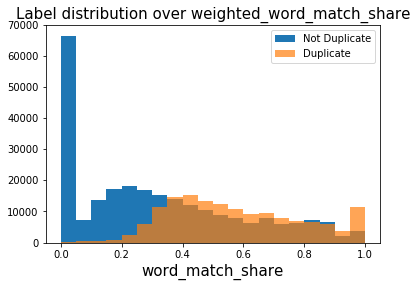

In [19]:
# word match share by weights

def weighted_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stopword:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stopword:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

weight_word_match = data.apply(weighted_word_match_share, axis=1, raw=True)

plt.hist(weight_word_match[data['is_duplicate'] == 0].fillna(0), bins=20, label='Not Duplicate')
plt.hist(weight_word_match[data['is_duplicate'] == 1].fillna(0), bins=20, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over weighted_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)